In [7]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import PIL

import glob
import os
import sys

from IPython.display import display

# Importation des données

In [8]:
targets = pd.read_csv("data.csv", sep = ",", index_col = 0)

In [9]:
df = pd.concat([targets.classes.value_counts(), targets.classes.value_counts(normalize = True)], axis = 1)
df.columns = ["number", "percent"]
df

number   percent
unknown            549  0.344417
door_dent          192  0.120452
bumper_scratch     164  0.102886
door_scratch       154  0.096612
glass_shatter      137  0.085947
tail_lamp          136  0.085320
head_lamp          133  0.083438
bumper_dent        129  0.080928

In [237]:
# Get paths
image_paths = glob.glob("Dataset/*.jpeg")

# Initialisation
images_np = np.ndarray([len(image_paths), 224, 224, 3])
images = []
nb_images = len(image_paths)

# Sorted images
num_image = np.array([x.split(sep = '/')[1].split('.')[0] for x in image_paths], dtype = 'int32')
df = pd.concat([pd.DataFrame(num_image), pd.DataFrame(image_paths)], axis = 1)
df.columns = ['num_image', 'id_image']
sorted_image_paths = df.sort_values(by = 'num_image').id_image


for i in range(len(sorted_image_paths)):
    
    images.append(PIL.Image.open(sorted_image_paths.iloc[i]))
    images_np[i ,:, :, :] = images[i]
    
# images = images.reshape([])
len_image = images_np[0].shape[1]

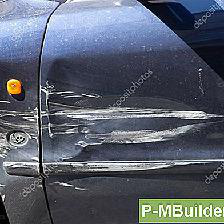

In [238]:
images[60]

### Dataset_dent

In [239]:
targets_dent = targets[targets.classes.isin(["unknown", "door_dent", "bumper_dent"])] 

In [240]:
df = pd.concat([targets_dent.classes.value_counts(), targets_dent.classes.value_counts(normalize = True)], axis = 1)
df.columns = ["number", "percent"]
df

number   percent
unknown         549  0.631034
door_dent       192  0.220690
bumper_dent     129  0.148276

In [241]:
dent_car_list = targets_dent.image.apply(lambda x: x.split(sep='/')[1].split(sep='.')[0]).index

In [256]:
dent_car_list

Int64Index([   0,    4,    5,    7,    9,   11,   12,   13,   15,   17,
            ...
            1489, 1491, 1492, 1494, 1496, 1501, 1505, 1507, 1509, 1510],
           dtype='int64', length=870)

# test 1 image

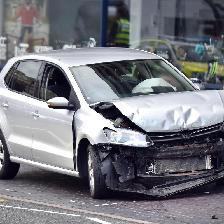

In [270]:
image = PIL.Image.open("Dataset/0.jpeg")
image

<AxesSubplot:>

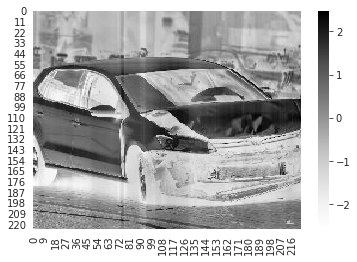

In [206]:
sns.set_style('whitegrid')
sns.heatmap(np_image_2[1, : ,:], cmap = 'Greys')

## Model

In [207]:
np_image = np.asarray(image)

np_image_2[0, :, :] = StandardScaler().fit_transform(np_image[:, :, 0])
np_image_2[1, :, :] = StandardScaler().fit_transform(np_image[:, :, 1])
np_image_2[2, :, :] = StandardScaler().fit_transform(np_image[:, :, 2])

In [213]:
# Flatten
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[224, 224]))

# Add the layers
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

# output
output = model.predict(np_image_2[0:1])
output

array([[0.12462063, 0.77835137, 0.09702796]], dtype=float32)

In [202]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               12845312  
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 771       
Total params: 12,846,083
Trainable params: 12,846,083
Non-trainable params: 0
_________________________________________________________________


# Multi image

## Normalization

In [245]:
images_np_dent = np.ndarray([len(dent_car_list), len_image*len_image, 3])
size = [len(dent_car_list), -1]


dent_car_set = images_np[dent_car_list]

images_np_dent[:, :, 0] = StandardScaler().fit_transform(dent_car_set[:, :, :, 0].reshape(size))
images_np_dent[:, :, 1] = StandardScaler().fit_transform(dent_car_set[:, :, :, 1].reshape(size))
images_np_dent[:, :, 2] = StandardScaler().fit_transform(dent_car_set[:, :, :, 2].reshape(size))

## Model

In [246]:
# Initialisation
model = tf.keras.models.Sequential()

# Add the layers
model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(3, activation="softmax"))

# Output
output = model.predict(images_np_dent[0:1, :, 0])

In [247]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               12845312  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 771       
Total params: 12,846,083
Trainable params: 12,846,083
Non-trainable params: 0
_________________________________________________________________


In [248]:
model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer= "sgd",
    metrics = ["accuracy"]
)

In [395]:
encoder = OrdinalEncoder(dtype = 'int')
encoder.fit(targets_dent[['classes']])
targets_dent = targets_dent.assign(ordinal_classes = encoder.transform(targets_dent[['classes']]))

In [396]:
X_train, X_test, y_train, y_test = train_test_split(images_np_dent[:, :, 0], 
                                                    targets_dent, test_size = 0.2, 
                                                    random_state = 0, shuffle = False)

In [397]:
history = model.fit(X_train, y_train.ordinal_classes, epochs = 100, validation_split= 0.2)

2021-11-19 14:50:04.258766: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 111591424 exceeds 10% of free system memory.


Epoch 1/100
18/18 [==============================] - 1s 40ms/step - loss: 8.7751e-04 - accuracy: 1.0000 - val_loss: 1.8858 - val_accuracy: 0.6071
Epoch 2/100
18/18 [==============================] - 1s 33ms/step - loss: 8.6896e-04 - accuracy: 1.0000 - val_loss: 1.8872 - val_accuracy: 0.6071
Epoch 3/100
18/18 [==============================] - 1s 33ms/step - loss: 8.5984e-04 - accuracy: 1.0000 - val_loss: 1.8886 - val_accuracy: 0.6071
Epoch 4/100
18/18 [==============================] - 1s 33ms/step - loss: 8.5208e-04 - accuracy: 1.0000 - val_loss: 1.8901 - val_accuracy: 0.6071
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 8.4408e-04 - accuracy: 1.0000 - val_loss: 1.8924 - val_accuracy: 0.6071
Epoch 6/100
18/18 [==============================] - 1s 33ms/step - loss: 8.3657e-04 - accuracy: 1.0000 - val_loss: 1.8933 - val_accuracy: 0.6071
Epoch 7/100
18/18 [==============================] - 1s 34ms/step - loss: 8.2831e-04 - accuracy: 1.0000 - val_loss: 1.8946 -

Epoch 57/100
18/18 [==============================] - 1s 32ms/step - loss: 5.6170e-04 - accuracy: 1.0000 - val_loss: 1.9461 - val_accuracy: 0.6071
Epoch 58/100
18/18 [==============================] - 1s 32ms/step - loss: 5.5826e-04 - accuracy: 1.0000 - val_loss: 1.9473 - val_accuracy: 0.6071
Epoch 59/100
18/18 [==============================] - 1s 32ms/step - loss: 5.5447e-04 - accuracy: 1.0000 - val_loss: 1.9483 - val_accuracy: 0.6071
Epoch 60/100
18/18 [==============================] - 1s 32ms/step - loss: 5.5075e-04 - accuracy: 1.0000 - val_loss: 1.9492 - val_accuracy: 0.6071
Epoch 61/100
18/18 [==============================] - 1s 33ms/step - loss: 5.4716e-04 - accuracy: 1.0000 - val_loss: 1.9495 - val_accuracy: 0.6071
Epoch 62/100
18/18 [==============================] - 1s 32ms/step - loss: 5.4393e-04 - accuracy: 1.0000 - val_loss: 1.9506 - val_accuracy: 0.6071
Epoch 63/100
18/18 [==============================] - 1s 31ms/step - loss: 5.4086e-04 - accuracy: 1.0000 - val_loss: 1

In [459]:
model.save('simple_nn_model.h5')

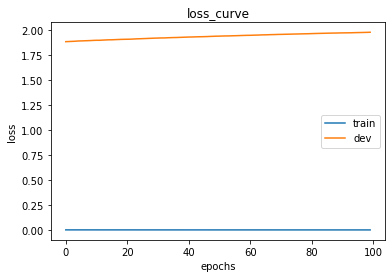

Text(0, 0.5, 'accuracy')

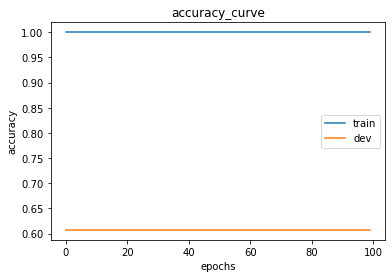

In [398]:
loss_train_curve = model.history.history['loss']
accuracy_train_curve = model.history.history['accuracy']

loss_dev_curve = model.history.history['val_loss']
accuracy_dev_curve = model.history.history['val_accuracy']


plt.plot(loss_train_curve, label = 'train')
plt.plot(loss_dev_curve, label = 'dev')
plt.legend()
plt.title('loss_curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

plt.plot(accuracy_train_curve, label = 'train')
plt.plot(accuracy_dev_curve, label = 'dev')
plt.legend()
plt.title('accuracy_curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')

## Predictions fausses

In [451]:
predictions = pd.Series(np.round(model.predict_classes(X_test)), index = y_test.index)

# Create onehot vectors
#encoderOneHot = LabelBinarizer()
#dent_oneHot_target = encoderOneHot.fit_transform(y_test.ordinal_classes)
#oneHot_prediction = np.array(predictions, dtype= 'int8')

images_dent = [images[i] for i in dent_car_list]
#images_wrong = [images_dent[i] for i in wrong_index]

wrong_index = y_test[y_test['ordinal_classes'] != predictions].index

print('Accuracy on test set ' + str(1-len(wrong_index)/len(y_test)))

Accuracy on test set 0.5919540229885057


0 : unknown
1 : door_dent
2 : bumper_dent


Image n° : 1216


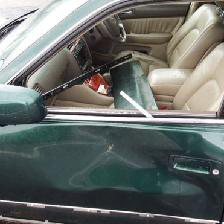

Prediction : 2
Label      : 1

Image n° : 1218


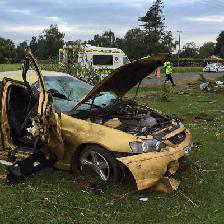

Prediction : 1
Label      : 2

Image n° : 1219


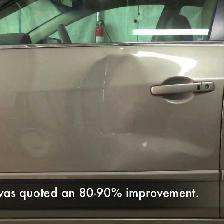

Prediction : 2
Label      : 1

Image n° : 1220


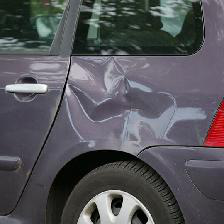

Prediction : 0
Label      : 1

Image n° : 1231


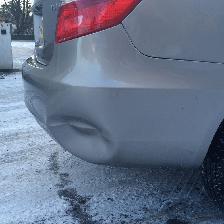

Prediction : 2
Label      : 0

Image n° : 1232


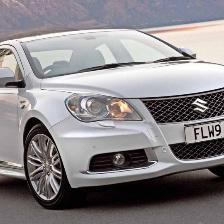

Prediction : 0
Label      : 2

Image n° : 1241


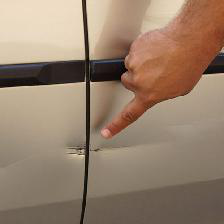

Prediction : 2
Label      : 1

Image n° : 1245


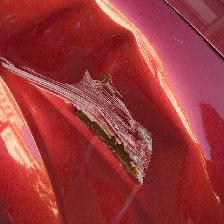

Prediction : 0
Label      : 1

Image n° : 1247


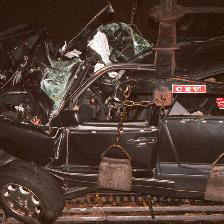

Prediction : 0
Label      : 2

Image n° : 1253


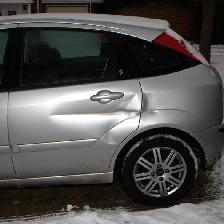

Prediction : 2
Label      : 1

Image n° : 1255


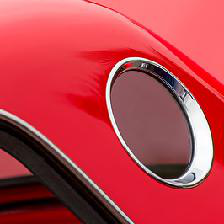

Prediction : 1
Label      : 2

Image n° : 1257


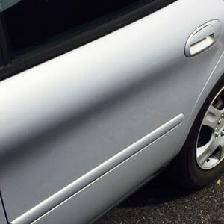

Prediction : 1
Label      : 2

Image n° : 1259


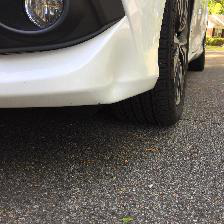

Prediction : 2
Label      : 0

Image n° : 1272


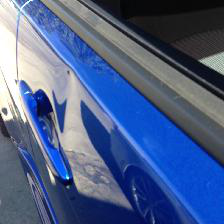

Prediction : 2
Label      : 1

Image n° : 1276


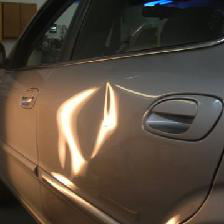

Prediction : 2
Label      : 1

Image n° : 1279


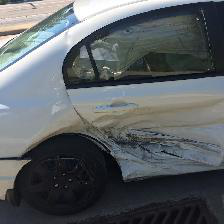

Prediction : 2
Label      : 1

Image n° : 1284


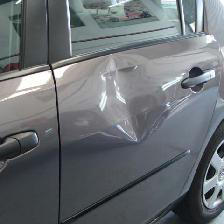

Prediction : 0
Label      : 1

Image n° : 1286


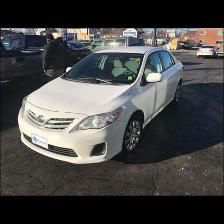

Prediction : 1
Label      : 2

Image n° : 1288


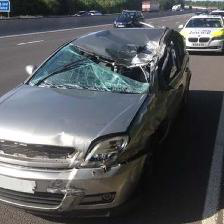

Prediction : 1
Label      : 2

Image n° : 1296


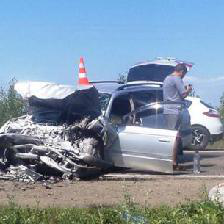

Prediction : 1
Label      : 2

Image n° : 1299


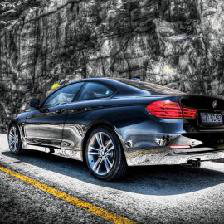

Prediction : 1
Label      : 2

Image n° : 1301


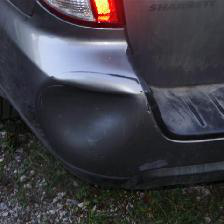

Prediction : 2
Label      : 0

Image n° : 1309


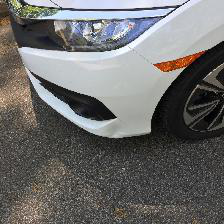

Prediction : 2
Label      : 0

Image n° : 1314


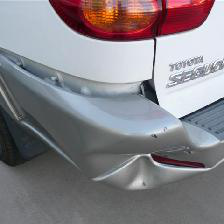

Prediction : 1
Label      : 0

Image n° : 1320


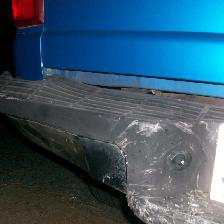

Prediction : 2
Label      : 0

Image n° : 1321


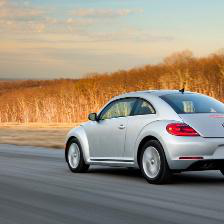

Prediction : 0
Label      : 2

Image n° : 1324


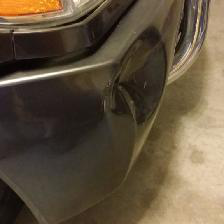

Prediction : 1
Label      : 0

Image n° : 1327


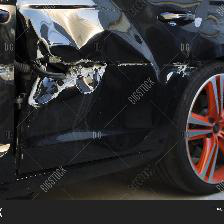

Prediction : 2
Label      : 1

Image n° : 1332


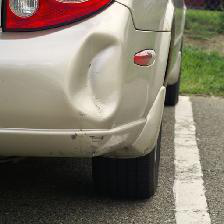

Prediction : 2
Label      : 0

Image n° : 1344


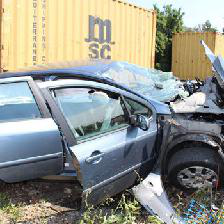

Prediction : 0
Label      : 2

Image n° : 1352


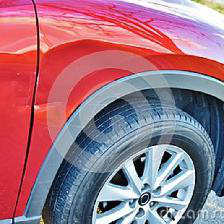

Prediction : 0
Label      : 1

Image n° : 1353


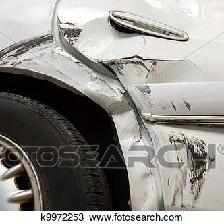

Prediction : 2
Label      : 1

Image n° : 1354


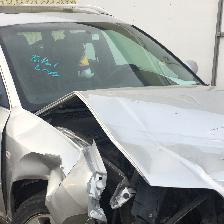

Prediction : 1
Label      : 2

Image n° : 1356


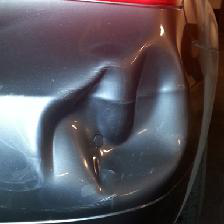

Prediction : 1
Label      : 0

Image n° : 1357


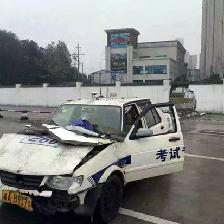

Prediction : 1
Label      : 2

Image n° : 1358


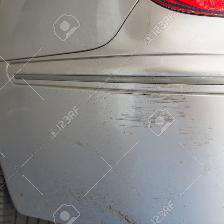

Prediction : 1
Label      : 0

Image n° : 1359


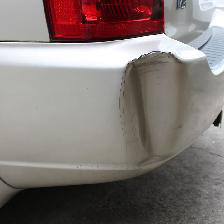

Prediction : 1
Label      : 0

Image n° : 1361


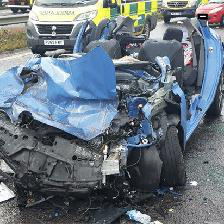

Prediction : 1
Label      : 2

Image n° : 1364


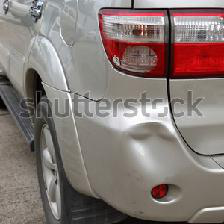

Prediction : 1
Label      : 0

Image n° : 1373


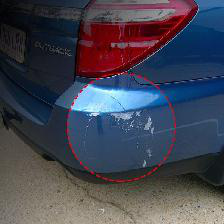

Prediction : 2
Label      : 0

Image n° : 1382


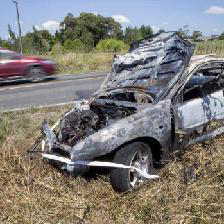

Prediction : 1
Label      : 2

Image n° : 1383


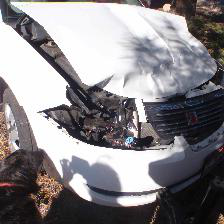

Prediction : 1
Label      : 2

Image n° : 1386


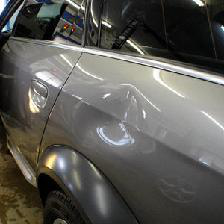

Prediction : 2
Label      : 1

Image n° : 1389


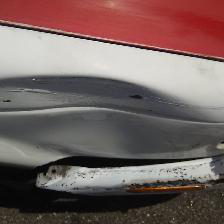

Prediction : 1
Label      : 0

Image n° : 1398


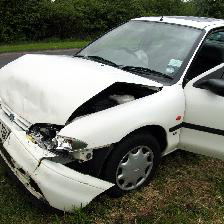

Prediction : 1
Label      : 2

Image n° : 1402


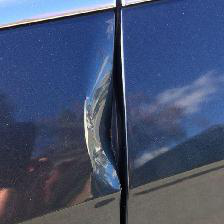

Prediction : 2
Label      : 1

Image n° : 1403


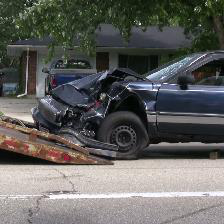

Prediction : 0
Label      : 2

Image n° : 1411


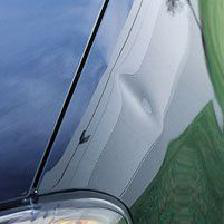

Prediction : 2
Label      : 1

Image n° : 1414


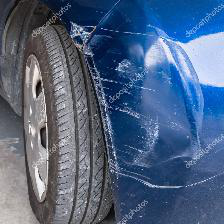

Prediction : 2
Label      : 0

Image n° : 1416


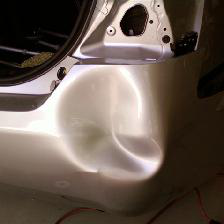

Prediction : 2
Label      : 0

Image n° : 1417


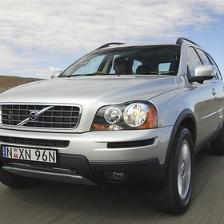

Prediction : 0
Label      : 2

Image n° : 1418


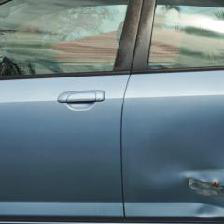

Prediction : 2
Label      : 1

Image n° : 1419


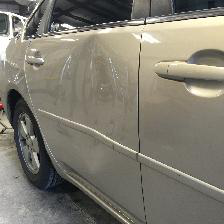

Prediction : 0
Label      : 1

Image n° : 1420


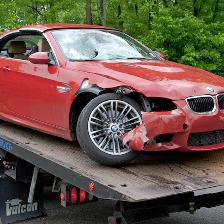

Prediction : 1
Label      : 2

Image n° : 1422


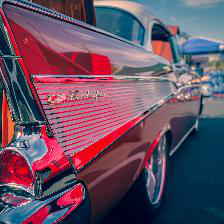

Prediction : 1
Label      : 2

Image n° : 1424


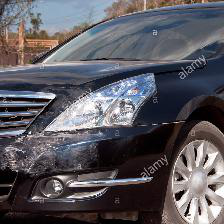

Prediction : 2
Label      : 0

Image n° : 1428


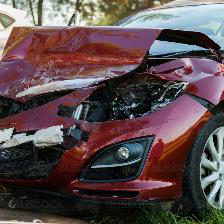

Prediction : 1
Label      : 2

Image n° : 1429


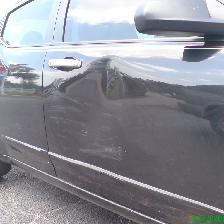

Prediction : 2
Label      : 1

Image n° : 1440


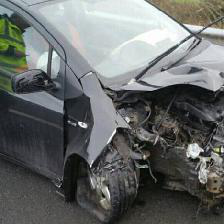

Prediction : 1
Label      : 2

Image n° : 1443


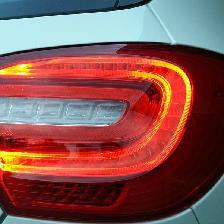

Prediction : 0
Label      : 2

Image n° : 1454


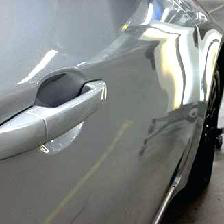

Prediction : 0
Label      : 2

Image n° : 1459


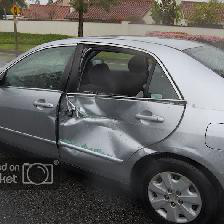

Prediction : 2
Label      : 1

Image n° : 1462


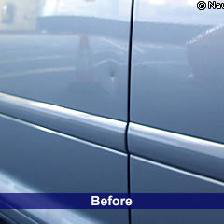

Prediction : 2
Label      : 1

Image n° : 1467


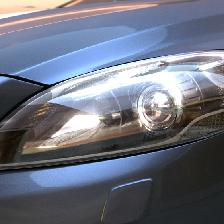

Prediction : 1
Label      : 2

Image n° : 1478


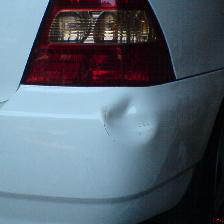

Prediction : 1
Label      : 0

Image n° : 1479


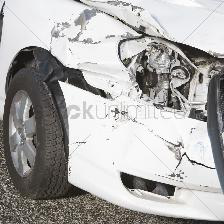

Prediction : 0
Label      : 2

Image n° : 1485


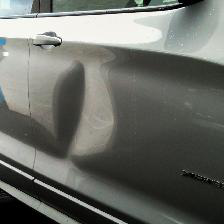

Prediction : 2
Label      : 1

Image n° : 1488


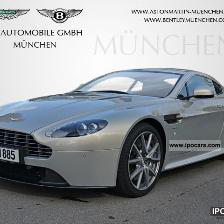

Prediction : 1
Label      : 2

Image n° : 1491


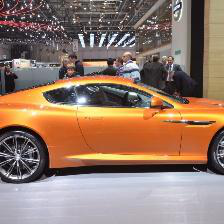

Prediction : 1
Label      : 2

Image n° : 1507


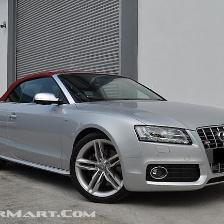

Prediction : 1
Label      : 2

Image n° : 1510


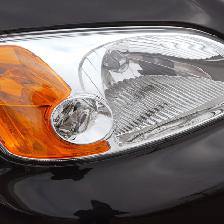

Prediction : 0
Label      : 2


In [449]:
r = 0

print("0 : unknown")
print("1 : door_dent")
print("2 : bumper_dent")
print()

for index in wrong_index:
    
    print()
    print('Image n° : ' + str(index))
    display(images[index])
    print('Prediction : ' + str(predictions[index]))
    print('Label      : ' + str(int(y_test.ordinal_classes[index])))
    
    if r == 30:
        break

In [346]:
dataset_dent.index

Int64Index([   0,    4,    5,    7,    9,   11,   12,   13,   15,   17,
            ...
            1489, 1491, 1492, 1494, 1496, 1501, 1505, 1507, 1509, 1510],
           dtype='int64', length=870)